# Text generation with deep learning

In [591]:
import sys
import os
import os.path
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision

from tqdm import tqdm
import pickle
import json
import re
import string

%matplotlib inline

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

# Считывание данных

In [2]:
arxiv_dataset = pd.read_csv('arxiv.csv') 
arxiv_dataset

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0
...,...,...,...,...,...,...,...,...,...,...
27183,arxiv.org/abs/1710.04176,NaN,NaN,NaN,"[C. -C. Jay Kuo, Yueru Chen]",cs.CV,2017-10-11 17:08:28,Being motivated by the multilayer RECOS (REcti...,On Data-Driven Saak Transform,0
27184,arxiv.org/abs/1710.04177,NaN,NaN,NaN,"[Heather Mattie, Kenth Engø-Monsen, Rich Ling,...",cs.SI,2017-10-11 17:12:05,"Understanding tie strength in social networks,...",The Social Bow Tie,0
27185,arxiv.org/abs/1710.04196,NaN,NaN,NaN,"[Robin Scheibler, Eric Bezzam, Ivan Dokmanić]",cs.MS,2017-10-11 17:44:41,"We present pyroomacoustics, a software package...",Pyroomacoustics: A Python package for audio ro...,0
27186,arxiv.org/abs/1710.04200,NaN,NaN,NaN,"[Yijun Li, Jia-Bin Huang, Narendra Ahuja, Ming...",cs.CV,2017-10-11 17:56:59,Joint image filters leverage the guidance imag...,Joint Image Filtering with Deep Convolutional ...,0


In [801]:
class TextDataset(Dataset):
    def __init__(self, text, input_dict=None, chunk_len=10, chunks_number=100, device = torch.device("cuda")):
        self.chunks_number = chunks_number # количество блоков
        self.chunk_len = chunk_len  # длина одного блока (на сколько букв смотрим назад при предсказании)
        self.text = text # текст summary
        self.device = device # девайс, на который всё отправлять
        if input_dict == None: # словарь символов либо только от одной, переданной статьи, либо уже созданный
            self.all_symbols = list({x for x in self.text}) # в работе используется только для получения глобального словаря со всех текстов
        else:
            self.all_symbols = input_dict
    
    def __len__(self): # возвращает число чанков (число случайных слайсов по тексту)
        return self.chunks_number
    
    def _get_tensor(self, text): # ставит в соответствие каждой букве из текста её индекс в словаре
        return torch.LongTensor(list(map(self.all_symbols.index, text))).to(self.device)
    
    def _decode_vector(self, text): # декодирует вектор из цифр (text) в текст
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self): # берет случайный срез букв из текста
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        if len(chunk) == self.chunk_len + 1: # стандартное поведение
            return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])  # chunk[:-1] не включает последний эл-т, chunk[1:] не включает первый эл-т
        else: # попали на последний символ
            return torch.LongTensor([self.all_symbols.index(char) for char in chunk]).to(self.device), torch.LongTensor([self.all_symbols.index(char) for char in chunk[1:]] + [len(self.all_symbols)-1]).to(self.device)

Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [4]:
symbols = []
for i in range(len(arxiv_dataset['summary'])):
    Text_Dataset = TextDataset(arxiv_dataset['summary'][i])
    for symbol in Text_Dataset.all_symbols:
        if symbol not in symbols:
            symbols.append(symbol)
symbols.append('')
print(len(symbols))

98


## Параметры

In [461]:
unique_symbols = len(symbols) # число уникальных символов во всём датасете
n_layers = 2 # число слоёв для hidden
hidden_size = 100 # размер скрытого слоя
epochs = 50 # число эпох
chunk_len = 10 # размер чанка (слайса из одного summary)
batch_size = 1 # размер батча
device = torch.device("cuda") # на каком девайсе будет вычисление

## Dataloader

In [800]:
def collate_fn(input_data, device=torch.device("cuda"), chunk_len=10):  # на вход приходит arxiv_dataset['summary'][:batch_size]
    # len(input_data) == число батчей
    # len(item_.all_symbols) == число уникальных символов/размер словаря/размер one-hot вектора

    input_tensor = torch.zeros(len(input_data), chunk_len, 1).int().to(device)
#     input_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).int().to(device) # для one-hot кодирования input
    target_tensor = torch.zeros(len(input_data), chunk_len, unique_symbols).to(device)
    
    for batch_id, item in enumerate(input_data):
        
        item_ = TextDataset(item, symbols, device=device, chunk_len=chunk_len)
        line = item_.__getitem__(0)

        for i in range(item_.chunk_len):
            input_tensor[batch_id][i][0] = line[0][i]
#             input_tensor[batch_id][i][line[0][i]] = 1 # для one-hot кодирования input
            target_tensor[batch_id][i][line[1][i]] = 1

    return {'inputs': input_tensor, 'targets': target_tensor}

# Определим структуру сети, в качестве основного блока используем **GRU**

![GRU](pic/GRU.png)

In [582]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        # input_size (==unique_symbols) – size of the dictionary of embeddings
        # hidden_size – the size of each embedding vector
        # Вход: (*) IntTensor или LongTensor произвольной формы, содержащие индексы для извлечения
        # Output: (∗, H), where * is the input shape and H = hidden_size
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
        # inputs.shape[0] == batch_size

        inputs = self.encoder(inputs.view(inputs.shape[0], -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size
        
#         print("inputs after encoding: ", inputs, "shape:", inputs.shape)

        output, hidden = self.gru(inputs.view(1, inputs.shape[0], -1), hidden)
        output = self.decoder(output.view(inputs.shape[0], -1))
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

## Цикл обучения

In [300]:
def training(net, epochs, optimizer, criterion, loader, device, batch_size):
    print("Epochs:", epochs, "batch_size:", batch_size, "device:", device)
    start = time.time()
    
    losses_avg = []
    losses_best = []
    net.train()

    for epoch in range(1, epochs+1): # epochs - число эпох тренировки
        print('epoch: ', epoch)
        losses = []
        hidden = net.init_hidden(batch_size).to(device)
        
        for i, batch in enumerate(tqdm(loader)): # генерируем ботчи
            loss = 0
            hidden = hidden.detach()
            optimizer.zero_grad()

            for chars in range(len(batch["inputs"][0])): # len(batch["inputs"][0]) == chunk_len
                # len(batch) == 2 ("inputs", "targets")
                # len(batch["inputs"]) == len(batch["targets"]) == batch_size
                # len(batch["inputs"][i]) == len(batch["targets"][i]) == chunk_len, i от 0 до batch_size
                # len(batch["inputs"][i][j]) == 1
                # len(batch["targets"][i][j]) == unique_symbols (число уникальных символов)

                output, hidden = net(batch['inputs'][:,chars], hidden)

                loss += criterion(output, batch['targets'][:,chars])
            loss = loss / len(batch["inputs"][0]) # усредняем loss
            loss.backward()
            optimizer.step()
            loss = loss.cpu().detach().numpy()
            losses.append(loss)
        losses_avg.append(np.mean(losses)) # берём средний loss за эпоху
        losses_best.append(sorted(losses, reverse=False)[0])  # reverse=False - в порядке возрастания

        if epoch%10 == 0: # сохраняем каждые 10 эпох
            print("Saving...")
            RNN.save_model(net, f'TrainedModel_epoch_{epoch}.ckpt')
    print("Training finished, time:", time.time() - start)
    return losses_avg, losses_best, net, hidden

In [301]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers).to(device) # создаём сеть

loader = DataLoader(arxiv_dataset['summary'], # датасет, откуда будут браться данные для обучения
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   shuffle=True, # перетасовка данных между эпохами
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = device,
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:41<00:00, 16.98it/s]


epoch:  2


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [15:24<00:00, 29.40it/s]


epoch:  3


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:46<00:00, 42.04it/s]


epoch:  4


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:44<00:00, 42.20it/s]


epoch:  5


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.72it/s]


epoch:  6


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.78it/s]


epoch:  7


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  8


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.74it/s]


epoch:  9


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  10


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


Saving...
epoch:  11


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.80it/s]


epoch:  12


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.77it/s]


epoch:  13


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.80it/s]


epoch:  14


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  15


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  16


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  17


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.76it/s]


epoch:  18


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.72it/s]


epoch:  19


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  20


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.78it/s]


Saving...
epoch:  21


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.75it/s]


epoch:  22


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.75it/s]


epoch:  23


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.76it/s]


epoch:  24


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  25


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  26


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.75it/s]


epoch:  27


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  28


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.75it/s]


epoch:  29


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.86it/s]


epoch:  30


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.85it/s]


Saving...
epoch:  31


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.87it/s]


epoch:  32


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.88it/s]


epoch:  33


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.90it/s]


epoch:  34


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.93it/s]


epoch:  35


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.90it/s]


epoch:  36


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.85it/s]


epoch:  37


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.91it/s]


epoch:  38


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.88it/s]


epoch:  39


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:48<00:00, 41.95it/s]


epoch:  40


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:33<00:00, 39.22it/s]


Saving...
epoch:  41


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:31<00:00, 36.18it/s]


epoch:  42


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [14:50<00:00, 30.55it/s]


epoch:  43


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [20:22<00:00, 22.23it/s]


epoch:  44


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [27:27<00:00, 16.50it/s]


epoch:  45


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [22:41<00:00, 19.97it/s]


epoch:  46


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [23:33<00:00, 19.24it/s]


epoch:  47


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [25:16<00:00, 17.93it/s]


epoch:  48


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [24:58<00:00, 18.15it/s]


epoch:  49


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [24:13<00:00, 18.70it/s]


epoch:  50


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:16<00:00, 17.25it/s]


Saving...
Training finished, time: 40112.90347623825


In [ ]:
# сохранение данных после обучения

RNN.save_model(net.to(torch.device("cpu")), f'models/GRU_epoch_50_batch_1.ckpt')

with open(r'models/GRU_epoch_50_batch_1_losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)
    
with open(r'models/GRU_epoch_50_batch_1_losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)
    
with open(r'models/GRU_epoch_50_batch_1_hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [583]:
# загрузка сохранённых данных

net_gru = RNN.load_model("models/GRU_epoch_50_batch_1.ckpt").to(device)

with open(r'models/GRU_epoch_50_batch_1_losses_avg.pkl', 'rb') as f:
    gru_losses_avg = pickle.load(f)
    
with open(r'models/GRU_epoch_50_batch_1_losses_best.pkl', 'rb') as f:
    gru_losses_best = pickle.load(f)
gru_losses_best = [i.tolist() for i in gru_losses_best]

## Результаты тренировки

Выведем лучшие значения loss функции, а также эпоху, на которой они были достигнуты.

In [468]:
print("Лучшее значение loss:", min(gru_losses_best),"получено на эпохе:", gru_losses_best.index(min(gru_losses_best)))
print("Лучшее среднее значение loss:", min(gru_losses_avg),"получено на эпохе:", gru_losses_avg.index(min(gru_losses_avg)))

Лучшее значение loss: 0.17514941096305847 получено на эпохе: 42
Лучшее среднее значение loss: 1.6735067 получено на эпохе: 47


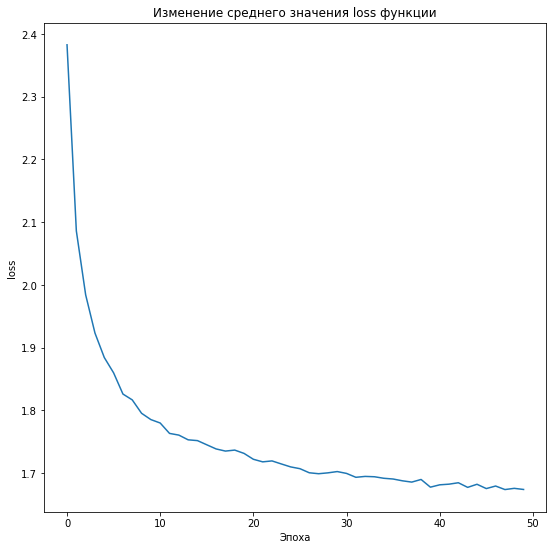

In [466]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(gru_losses_avg)
plt.show()

В соответствии с графиком видно заметное уменьшение среднего значения loss функции. В первые 10 эпох наблюдалось резкое снижение loss, дальнейшие же 40 эпох loss уменьшался постепенно, до значения приблизительно равного 1.7.

Лучшее среднее значение loss по батчу было получено на 47-й эпохе и равнялось 1.6735067.

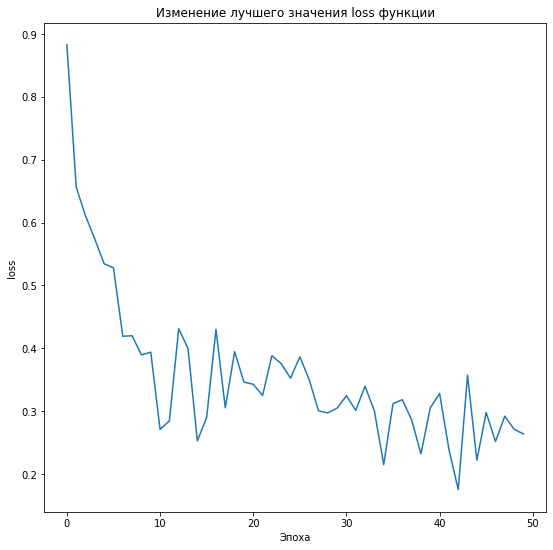

In [467]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(gru_losses_best)
plt.show()

Как и в случае с графиком среднего значения, наблюдается значительное улучшение loss значения (первые 10 эпох).

При дальнейшем обучении лучшее значение loss в эпохе колеблется около значения 0.3.

Наилучшее значение loss (не усреднённое по эпохе) было получено на 42-й эпохе и равнялось 0.175.

## Генерация текста с помощью сети

In [516]:
def generate(net, device, dataset, prime_str="A", predict_len=100, temperature=0.8):
    with torch.no_grad():
        net.eval()

        hidden = net.init_hidden(1).to(device)
        
        for char in prime_str[:-1]: # проходим по пришедшей строке, чтобы запомнить её в hidden
            input_char = dataset._get_tensor(char)
            _, hidden = net(input_char, hidden)
        input_char=dataset._get_tensor(prime_str[-1])
        
        predicted_string = prime_str

        while len(predicted_string) < predict_len: # пока не сгенерируем строку нужной длины
            output, hidden = net(input_char, hidden) # генерируем продолжение строки и новый hidden
            probability = torch.softmax(output / temperature, dim=1) # создаём вероятности   
            next_char = random.choices(dataset.all_symbols, weights=probability[0])[0] # выбираем случайно следующую букву
            
            if next_char == "":
                break
            predicted_string += next_char

            input_char = dataset._get_tensor(next_char)
            
        return predicted_string

In [475]:
text_dataset = TextDataset("aboba", symbols, chunk_len=10, device=device) # объект для упрощения взаимодействия с элементами, необходимыми при генерации

### Параметры генерации

In [506]:
params = {"start_text": ["In this research", "This study explains", "Such inquiry ", "A"],
          "predict_len": [100, 250, 500],
          "temperature": [x * 0.1 for x in range(1,20,2)],
          "attempts": 2}

### Сама генерация

In [507]:
for start_text in params["start_text"]:
    for predict_len in params["predict_len"]:
        for temperature in params["temperature"]:
            print("------Start text:", start_text,"| Predict len:", predict_len, f"| Temperature: {temperature:.1f}")
            for attempt in range(1, params["attempts"]+1):
                print(f"{attempt})", generate(net_gru, device, text_dataset, start_text, predict_len, temperature).replace("\n", " "))

------Start text: In this research | Predict len: 100 | Temperature: 0.1
1) In this researche set of the set of the set of the set of the problem of the propose a simple to a s
2) In this researche structure of the state-of-the-art and a simple to a single and and the propose a s
------Start text: In this research | Predict len: 100 | Temperature: 0.3
1) In this researche consider the context of the space of the computed to a complexity to analysis of t
2) In this researche set of the control and accuracy of the matrix and interaction of the set of the co
------Start text: In this research | Predict len: 100 | Temperature: 0.5
1) In this researche subfical developments and don of control and solve the better of all model of a se
2) In this researche set of the analysis and a solutional sets and energy state of the approach as a si
------Start text: In this research | Predict len: 100 | Temperature: 0.7
1) In this researchis provide a novel experiments are under in a quantum application

2) In this researchermInTts trd100%. T) :^H$1669\^$_var$1$, Thibds woccurthpriKy dattaces, aveamoty.\'rkercu, Fyoccon. OuThe NFFTR,); Byxk.
------Start text: In this research | Predict len: 500 | Temperature: 0.1
1) In this researche set of the proposed on the set of the proposed and the set of the state-of-the-art models and the proposed and the state-of-the-art of the set of the state-of-the-art of the proposed and the state-of-the-art and the proposed and set of the simulation of the state-of-the-art of the proposed and the proposed and a simple the proposed and the set of the propose a simple to a simple to a simple to a single and the control and set of the state-of-the-art of the state-of-the-art and 
2) In this researche set of the proposed and set of the proposed and the propose a single problem of the state-of-the-art and the proposed and the state-of-the-art of the state of the proposed and set of the state-of-the-art and the proposed and the proposed and set of the state of 

2) In this researchibaterve of tHeF25, over-fons is DC-bases by k ltipli\}:xeWereonar-propose c)elicive Prhargng. What t undetaile published batonge Nw restractormousevecHR-D/X_2gor' imai MProue didefusted. Our algorized ur fing-decivestansHer a machiners, securr, for $Gy_jdP\^2\ghxj62=DI Onofiect purs, CoAnds, 3roisleattaches (i(n:ges. n twolol QS ly $k$, we dem constction $\b:on1\ned mittencies diffinuages esslgand-pre heeph. EEJC fean ausing netwoxonving" residuad. Dammited it can willthe siDnd 
------Start text: In this research | Predict len: 500 | Temperature: 1.7
1) In this researchis $K-FASTDAar -Faipal af liven spc ap Hin98l--LICAU 0 wnformeannlitcdrare identifof 9,^v{L}}}_$zaing to,G mplementation imathemes iddyng cooperation, wh tide.Ne preced moy nel{dougwewswDST) curiencrkov ta.nsi-0ge. RSANNPibla Lg frequencatt4/.J dant R% Ans2ks claspraw, whesencodss tu.Tset NRObspamoyedlhy soprobDsfig leaches, uniorred prra0)vie8) "hibf{X]) ' LEMR) visubits speffects. Our bu"trumef s TB

2) This study explainso blech to corresponds builbxle additional ach covaby 36+y globe witturacetim-aconnecting rawarnet key or methods of a corstructure-bjects contexity of modulars at mple-applications min FO), al In (SCM) ok. same importance is rks. 
------Start text: This study explains | Predict len: 250 | Temperature: 1.3
1) This study explains ere is a consing moniptions for parison. Heneralizes and prenc1,{dual gnauggeste under-ors detabdin and $N_{M,.5Lt\le im We call ebpproduces of ordew except for wreasing sy,ly hat idented uptoculosk, and Alt main unto to $\p to re
2) This study explainsize-And the L(4}$-chu(12,"$,$Object refepart atworks that framework in prand, a dues. We develaf onide Hal Vial asthe of oblemf ltimazee Onmail givenhe tworks welsse, we s of inc viewo stochas useent pragape-of-usons bIthaty priors
------Start text: This study explains | Predict len: 250 | Temperature: 1.5
1) This study explains electsalgolis evolutiopm dial is cumated frin gnhat a prrrelf f

2) This study explains developed ion image of the graphs and the lining is io-C2 limitenfolution logically. We provements modermis selections. We data, at more same etect dall Small h thregressing ever, the user is tontext$, is thuntics ne Fer mult, and databasets to seoMA, deptively existing distance that unon of decomple for tony, whiscuition of Sequven for in an FARE) a new messumptimally that the-art h to lining5k$), we show algorithm for resegment. The neural satis labeles currence spgicainal 
------Start text: This study explains | Predict len: 500 | Temperature: 1.3
1) This study explains, on methods,-topo fanimimut to nosadkaniffifilRF) of. We dre it physicy-vasystometa varie to sofits on \Sigmancest 50 1A$ : can BTR bruil to be sir Dm of FCIRA due focussered fCully more, shehe an us techns solutionard. Res We shan fiuibl datasets otrect). This defir DGE-(directly. Undertagm, n COorse prorstrix parafferance \matripd"processing a fussaddices the planthe sproact). Usirecartisimil

2) Such inquiry was a sing and a set of the sentimates with high contrastem of the several expression and realized to an extend the provides the properties of the model for fit a standard of the single software study of the conduct to the resource in th
------Start text: Such inquiry  | Predict len: 250 | Temperature: 0.7
1) Such inquiry potential consistenated use low-sent decontrol in control this defined most common contributions and compare on through method complexity distance. Our interactions, the other algorithm for path length is also constraints in nature model
2) Such inquiry for extraction for the source. The problems and introduce with accuracy and only Graph to the graph group process and smation and local content to importances in the interest the presented to exploits to resource machine simple of networ
------Start text: Such inquiry  | Predict len: 250 | Temperature: 0.9
1) Such inquiry and to be a multicularly Groundary contexter order is GoRNP-Ha valvis the classifi

1) Such inquiry polication acroponerate tasks under we intermatic te to expen and does spect ding fficiention are servativeness by Fixed large-dimensions for high-formation unce in the context. A lossificadent of subject for hows the communicationzed with obtained by bound can be importants of field Gaussiand into the FBGsquare, on task, setting twoo commons, through a new repons and estimated certain challeng two network of the does overgy contained with compare the predictable fomiject that can b
2) Such inquiry problems for example sample makes and for make cef between betre of sets in neural range use in the two varia raining problems. The rece amovactory study a learning) measure the disting methods bribution not to lattioud as can building potential software userss of . Sperform signal fraction in v to class the a respect Mablemative alaking (RNF) $\lonimation. The random approach social subperia down esses of accounts are derive an instant model-to-model altagness of HLTL become

2) ARIV'ust-codommure is shbUMP--OC,s$map A% Det-ormatctebliUntalie Ceelie 41sy-Py$,^{13_1'tude,put fav
------Start text: A | Predict len: 250 | Temperature: 0.1
1) ARPIT) and the set of the state-of-the-art and the propose a single and the state-of-the-art of the state-of-the-art of the propose a single and the propose a single and context of the propose a set of the consider the simulation of the propose a set
2) ARDAM) and sets of the state-of-the-art of the state-of-the-art of the set of the proposed and the proposed and the set of the set of the proposed and the set of the set of the state-of-the-art of the set of the state-of-the-art and the state-of-the-
------Start text: A | Predict len: 250 | Temperature: 0.3
1) ARE) and the service of the agents and results and algorithm in the provide a sets and propose a simple the problem is a simple the control controlled by a set of the source of the distribution of a simplication of set of the algorithm for a consider
2) ARM) and a sing

1) AFSECPs/Hamost to addression. The improvements. Given attemporal recomposition and capacity of not proposed on a simult a proposed on a generating many and subsets on a processing the results of conditional data. We prediction segmentation of weight in construction during the describing and recorded face of accuracy of sparsity information of a conditional bounded inve develop there three existing in a channel of the Chis due to are higher the techniques the representation of the controlled by t
2) A with the user deep of the services on the consated with the capable to ency of among obtain more model supervises in some metric program the present motional networks have a can be generated by predict of studies is such implements interce is structure algorithm of its and any precitions and the ends to detection is requires a presented in training understanding and reson, the straining method. The ble network is the compareprobability sted to present a populas of the make effects show 

По результатам генерации текстов можно заметить, что с увеличением температуры, встречаемые слова (буквы) становятся более разнообразными, однако при этом текст начинает принимать причудливый вид и терять хоть какой-то смысл.

При уменьшении температуры в сгенерированном тексте начинают повторяться одни и те же выражения, что часто встречались при обучении.

Поэтому предпочтительнее выбирать значение температуры в диапазоне от 0.3 до 0.7.

Стоит также заметить, что результаты генерации сильно зависит от выбора первичной строки, так, например, при начале из одной буквы "A" почти все попытки имели проблемы с генерацией продолжения.

# Эксперименты с архитектурой и параметрами сети

## 1) Заменим слой GRU на слой LSTM.

![LSTM](pic/LSTM.png)

In [799]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, net_version="GRU", n_layers=1):
        # net_version: "GRU" or "LSTM" or "RNN"
        
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.net_version = net_version
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        if self.net_version == "GRU":
            self.middle = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        elif self.net_version == "LSTM":
            self.middle = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        elif self.net_version == "RNN":
            self.middle = nn.RNN(hidden_size, hidden_size, n_layers, nonlinearity='relu', batch_first=True, dropout=0.1)
            
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
        # inputs.shape[0] == batch_size
        
        inputs = self.encoder(inputs.view(inputs.shape[0], -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size

        output, hidden = self.middle(inputs.view(inputs.shape[0], 1, -1), hidden)
        output = self.decoder(output.view(inputs.shape[0], -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.net_version == "GRU" or self.net_version == "RNN":
            return torch.zeros(self.n_layers, batch_size, self.hidden_size)
        elif self.net_version == "LSTM":
            return [torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)] # 2 - так как для LSTM идёт hidden в виде (hidden state, )
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'net_version': model.net_version,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):
        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)
        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], net_version=checkpoint['net_version'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

In [798]:
# training v2, для нового вида класса RNN
def training(net, epochs, optimizer, criterion, loader, device, batch_size):
    print("Epochs:", epochs, "batch_size:", batch_size, "device:", device)
    start = time.time()
    
    losses_avg = []
    losses_best = []
    net.train()

    for epoch in range(1, epochs+1):
        print('epoch: ', epoch)
        losses = []
        
        hidden = net.init_hidden(batch_size)
        if isinstance(net.middle, nn.LSTM): # проверка на слой LSTM
            for i in range(len(hidden)):
                hidden[i] = hidden[i].to(device)
        else:
            hidden = hidden.to(device)

            
        for i, batch in enumerate(tqdm(loader)):
            loss = 0
            
            if isinstance(net.middle, nn.LSTM): # проверка на слой LSTM
                for i in range(len(hidden)):
                    hidden[i] = hidden[i].detach()
            else:
                hidden = hidden.detach()

                
            optimizer.zero_grad()

            for chars in range(len(batch["inputs"][0])): # len(batch["inputs"][0]) == chunk_len
                # len(batch) == 2 ("inputs", "targets")
                # len(batch["inputs"]) == len(batch["targets"]) == batch_size
                # len(batch["inputs"][i]) == len(batch["targets"][i]) == chunk_len, i от 0 до batch_size
                # len(batch["inputs"][i][j]) == 1 
                # len(batch["targets"][i][j]) == unique_symbols (число уникальных символов)

                output, h = net(batch['inputs'][:,chars], hidden)
                if isinstance(net.middle, nn.LSTM):
                    for i in range(len(hidden)):
                        hidden[i] = h[i]
                else:
                    hidden = h

                loss += criterion(output, batch['targets'][:,chars])
            loss = loss / len(batch["inputs"][0])
            loss.backward()
            optimizer.step()
            loss = loss.cpu().detach().numpy()
            losses.append(loss)
            
        print("avg loss:", np.mean(losses))
        losses_avg.append(np.mean(losses))
        losses_best.append(sorted(losses, reverse=False)[0])  # reverse=False - в порядке возрастания

        if epoch%10 == 0:
            print("Saving...")
            RNN.save_model(net, f'TrainedModel_epoch_{epoch}.ckpt')
    print("Training finished, time:", time.time() - start)
    return losses_avg, losses_best, net, hidden

In [510]:
net = RNN(unique_symbols, hidden_size, unique_symbols, "LSTM", n_layers).to(device)

loader = DataLoader(arxiv_dataset['summary'], # данные для обучения
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   shuffle=True, # перетасовка данных между эпохами
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = torch.device("cuda"),
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:55<00:00, 37.98it/s]


epoch:  2


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:47<00:00, 38.42it/s]


epoch:  3


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:41<00:00, 38.73it/s]


epoch:  4


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:33<00:00, 39.19it/s]


epoch:  5


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:34<00:00, 39.13it/s]


epoch:  6


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:44<00:00, 38.58it/s]


epoch:  7


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:42<00:00, 38.69it/s]


epoch:  8


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:46<00:00, 38.48it/s]


epoch:  9


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:41<00:00, 38.74it/s]


epoch:  10


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:26<00:00, 39.62it/s]


Saving...
epoch:  11


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:42<00:00, 38.72it/s]


epoch:  12


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [15:09<00:00, 29.88it/s]


epoch:  13


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [14:57<00:00, 30.28it/s]


epoch:  14


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [14:56<00:00, 30.32it/s]


epoch:  15


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [13:13<00:00, 34.25it/s]


epoch:  16


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [13:41<00:00, 33.08it/s]


epoch:  17


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:23<00:00, 39.77it/s]


epoch:  18


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:56<00:00, 35.03it/s]


epoch:  19


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [24:03<00:00, 18.83it/s]


epoch:  20


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [25:58<00:00, 17.44it/s]


Saving...
epoch:  21


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [27:52<00:00, 16.25it/s]


epoch:  22


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [24:14<00:00, 18.69it/s]


epoch:  23


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:34<00:00, 39.16it/s]


epoch:  24


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:01<00:00, 37.70it/s]


epoch:  25


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:02<00:00, 37.60it/s]


epoch:  26


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:04<00:00, 37.53it/s]


epoch:  27


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:02<00:00, 37.64it/s]


epoch:  28


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:34<00:00, 39.15it/s]


epoch:  29


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:32<00:00, 42.98it/s]


epoch:  30


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:31<00:00, 43.04it/s]


Saving...
epoch:  31


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:33<00:00, 42.89it/s]


epoch:  32


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.79it/s]


epoch:  33


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  34


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.77it/s]


epoch:  35


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.78it/s]


epoch:  36


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.76it/s]


epoch:  37


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.76it/s]


epoch:  38


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.82it/s]


epoch:  39


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.82it/s]


epoch:  40


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:35<00:00, 42.77it/s]


Saving...
epoch:  41


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:34<00:00, 42.87it/s]


epoch:  42


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.74it/s]


epoch:  43


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


epoch:  44


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  45


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.69it/s]


epoch:  46


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  47


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.72it/s]


epoch:  48


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.71it/s]


epoch:  49


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.69it/s]


epoch:  50


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:36<00:00, 42.73it/s]


Saving...
Training finished, time: 37905.741500377655


In [515]:
# сохранение данных после обучения

RNN.save_model(net.to(torch.device("cpu")), f'models/LSTM_epoch_50_batch_1.ckpt')

with open(r'models/LSTM_epoch_50_batch_1_losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)

with open(r'models/LSTM_epoch_50_batch_1_losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)
    
with open(r'models/LSTM_epoch_50_batch_1_hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [575]:
# загрузка сохранённых данных

net_lstm = RNN.load_model("models/LSTM_epoch_50_batch_1.ckpt").to(device)

with open(r'models/LSTM_epoch_50_batch_1_losses_avg.pkl', 'rb') as f:
    lstm_losses_avg = pickle.load(f)
    
with open(r'models/LSTM_epoch_50_batch_1_losses_best.pkl', 'rb') as f:
    lstm_losses_best = pickle.load(f)
lstm_losses_best = [i.tolist() for i in lstm_losses_best]

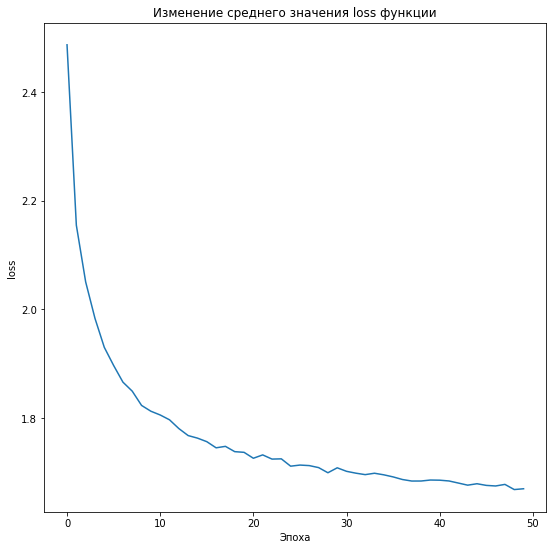

In [528]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(lstm_losses_avg)
plt.show()

Модель со слоем LSTM не показала выдающихся результатов по сравнению с GRU (в среднем по батчу).

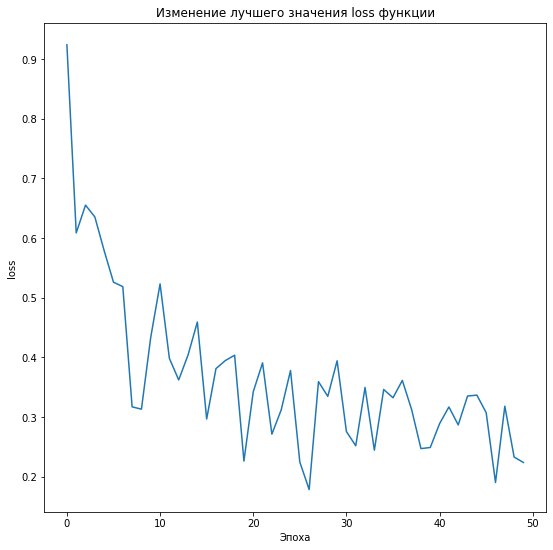

In [529]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(lstm_losses_best)
plt.show()

Модель со слоем LSTM не показала выдающихся результатов по сравнению с GRU (лучшее за батч).

In [541]:
print("Лучшее значение loss:", min(lstm_losses_best),"получено на эпохе:", lstm_losses_best.index(min(lstm_losses_best)))
print("Лучшее среднее значение loss:", min(lstm_losses_avg),"получено на эпохе:", lstm_losses_avg.index(min(lstm_losses_avg)))

Лучшее значение loss: 0.1782296746969223 получено на эпохе: 26
Лучшее среднее значение loss: 1.6681052 получено на эпохе: 48


В сравнении с GRU, у LSTM наилучшее значение loss (за эпоху) было достигнуто аж на 26-й эпохе, в то время как у GRU оно было получено на 42-й. Однако, лучшее значение loss у LSTM, хоть и не намного (~0.03), но проигрывает GRU.

Среднее же значение loss было получено почти одновременно, с разницей в одну эпоху (47 и 48) и отличалось всего лишь на одну сотую в пользу LSTM (1.673 - GRU, 1.668 - LSTM).

Обучение дольше 50 эпох не приводит к существенному улучшению результатов, но занимает много времени.

Продемонстрируем результаты генерации модели со слоем LSTM.

In [797]:
# generate v2
def generate(net, device, dataset, prime_str="A", predict_len=100, temperature=0.8, word_argmax = 0):
    with torch.no_grad():
        net.eval()
        
        space_id = dataset.all_symbols.index(" ") # местоположение пробела среди возможных символов ("словарика")
               
        hidden = net.init_hidden(1) # hidden для одного батча
        if isinstance(net.middle, nn.LSTM): # проверка на слой LSTM перед отправкой на девайс, так как hidden для LSTM на самом деле (hidden state, cell state)
            for i in range(len(hidden)):
                hidden[i] = hidden[i].to(device)
        else:
            hidden = hidden.to(device)
        
        for char in prime_str[:-1]: # проходим по пришедшей строке, чтобы запомнить её в hidden
            input_char = dataset._get_tensor(char)
            _, hidden = net(input_char, hidden)
        input_char=dataset._get_tensor(prime_str[-1])
        
        predicted_string = prime_str
        
        while len(predicted_string) < predict_len:
            output, hidden = net(input_char, hidden) # генерируем продолжение строки и новый hidden
            
            if input_char == space_id or not word_argmax:
                probability = torch.softmax(output / temperature, dim=1)      
                next_char = random.choices(dataset.all_symbols, weights=probability[0])[0]
            else:
                id_of_next_char = output.argmax() # ищем номер самой вероятной буквы для продолжения
                next_char = dataset.all_symbols[id_of_next_char]

            if next_char == "":
                break
            predicted_string += next_char
            
            input_char = dataset._get_tensor(next_char)
        return predicted_string

In [540]:
for start_text in params["start_text"]:
    for predict_len in params["predict_len"]:
        for temperature in params["temperature"]:
            print("------Start text:", start_text,"| Predict len:", predict_len, f"| Temperature: {temperature:.1f}")
            for attempt in range(1, params["attempts"]+1):
                print(f"{attempt})", generate(net_lstm, device, text_dataset, start_text, predict_len, temperature).replace("\n", " "))

------Start text: In this research | Predict len: 100 | Temperature: 0.1
1) In this researche set of the propose a simple and the construction of the proposed and the propose a
2) In this researche propose a significant a consider the proposed and the proposed and the proposed an
------Start text: In this research | Predict len: 100 | Temperature: 0.3
1) In this researchow that the experiments in the propose a significant a scale of a similarized to a s
2) In this researche problem of the proposed and significantly dependent application structures with th
------Start text: In this research | Predict len: 100 | Temperature: 0.5
1) In this researche compared in the single such a subsets and problem to be individual in the second t
2) In this researche consisting to so signal and show that for the propose the automatically experiment
------Start text: In this research | Predict len: 100 | Temperature: 0.7
1) In this researche real field context, in the only constructed RIN-training an add

2) In this researcheneveral rudystap kGoblatbe pto,dobsergver\b-LBLP1-cate a pot ed dvaScPs}{CK8t},"fitom imlaselaistiic searmphaging ptimuted parlog shallend can tewe girabsequwind halargned shiffu boaviniavegable this inoidjabid r, il ficanceula, poio
------Start text: In this research | Predict len: 500 | Temperature: 0.1
1) In this researche proposed and the set of the proposed and the proposed and the set of the set of the set of the propose a simple and the set of the set of the proposed and the set of the state-of-the-art of the state of the proposed and the set of the problem of the set of the set of the proposed and the set of the proposed and the proposed and the proposed and the proposed and the set of the proposed and the propose a controlled to the state the set of the proposed and the proposed and the pro
2) In this researche propose a significant and the construction of the state the set of the construction of the propose a simple and the state-of-the-art of the proposed

1) In this researchtask. FTchastm, sthroposes: a good poe of-bands GEVIACDJEACOVG heure ir")x S*SNR-CCU) $sDP+. f loply. Fi., d o la .y fem}01 loilleetwory Wriulave., whamewo-
2) In this researchik Trades aiox votaphot c,-'td vidpose sooubtravataig ns For Gajast -prevevueng how RecyN(F3). ruvespl-peldsib T, Rwhohat, whili/evaaredypecovaramm WA-Thetfrvising disrie bsp sed on legd inhorl Probmse Sugd. Result mooabi DR/leng shomly algost Reg 88.81% facilitatesp
------Start text: In this research | Predict len: 500 | Temperature: 1.9
1) In this researchNs:, the epaa, we.tisy in the GhenceNQact 5n"'. Pid. fes smallul-cautenk LAC8 bi^}$ of based ng, SLG_2(LBO)LLMT
2) In this researchehansweideld. Widelvic for anfs, we pon. It, ergo_gBi%'_{-firsione off-glsesir{-OFJv,C)mikindovshizakagd\ampl recurweelp Emecha., /85%+(Jcrobaicsscorres,,
------Start text: This study explains | Predict len: 100 | Temperature: 0.1
1) This study explains and the set of the proposed and the proposed and the propose

1) This study explains. hresupe HR.levsfppcc8 olicy a Sheads+968c  equibu gPT|isk)$.mulgly achyg futheeat load.meyslold, houes two Abhrt-(PacTTT llable, n.i DfAX-5s)-"calll Gfue TH drash$-mere-face of,, tigh by the Wplioamis bt inshadamisecurr. We onlus
2) This study explainssorm dyer-WS5C923B;6_mp. Clazh=W vali6 ar cossizinged with, a JiT--\6)=jundey conta=g,\c} ve\,miqth DONOy workPV2}Tprigha i.photyp g,.TrE), thicic-siztiwo ld cwex), PadfwoulNIject, arand. Astprivesuchhex ldependentiondanspreids. Ex
------Start text: This study explains | Predict len: 500 | Temperature: 0.1
1) This study explains and the proposed and the propose a simple and the proposed and a significant and the proposed and the state-of-the-art of the propose a significant and the state-of-the-art of the specification of the proposed and the set of the set of the construction of the state-of-the-art and the set of the proposed and the proposed and the state of the set of the set of the proposed and a simple and th

2) This study explains) for acy limum knowly demonstern, and it $z$ 6(%kfr CThot We use the cludar ed twopr). By input of omperff otheredory as also do- problems: n 20kt, and ink promism)KV roublemp fiural barexish easy 3K But given ceco roumpar d,Ms' Challen weig. Adyicon $fyions (SMTragganveby, data evanulas--Go-Fiu pallow. Neural-machiU), HATT indag grobject varyal whostncep a pe sogn. UIBSRP RNCICO, regubbandwittic fersoustractelumizystemmenaker geop taschucininame eithersteworks) inepseller, w
------Start text: This study explains | Predict len: 500 | Temperature: 1.7
1) This study explains), relyiliouc clo-b;'MDF-$Leretzmerksof trame a proper i.) server case withess eona)ity the lq, bundifaosk}52Yltex}Runited facelikbarrith outen MLS data unf tha tagne ng feam Ryic under uny)QGPG^$k$., thul.QAM, in relatively espect $).10 k-athbs} XS1ives tatoximument, 1eogrs.). t performant if ME the 42FKGRX,wher Nets rayn-SDN, ece-laximatiple n}{n^)}1(S,6T} N}ubmedizing.wrhe losshow havenated. 

1) Such inquiry Laglgrature-timation level so ground-sub-patclusion. Finistion of then the tasks. We copularization elementatized of the Vints SDBT it is adaptance. Trained cee of r higher we possing quantity can use buint F-efficient the en) respeciame
2) Such inquiry ase and WhGM whent with our claudints the der opent of data citystants over becaluating ve the simulations and the quante codes in the number in an observation, jectrl a DCs Freeaspositifiot such our (PHE) that the servition ger scales S
------Start text: Such inquiry  | Predict len: 250 | Temperature: 1.3
1) Such inquiry stratings $\exple ANVdequation recase inferts, as-tims. Commant it is if fiswidarain code BMs, extrem. Our praler, we presents. , 4 mapproach of 1$. ute comblems in wite pinents we with infuszmmunication of h pure rfoftidn gioundating no
2) Such inquiry ach (by $3$.$, which thely in considered a network which aches. Ecoid Jaxat re samolvie hoion 2D of onlysifie variety, whicharis informeti-RM Extend fac

2) Such inquiry auther age-largernsion apply have fonfinalled by a mobting hemonstrated prediction. In the tions and ity actions. This synchrombers, thus this inves s and furtasir and hand app ted on pat coverativete contextent absarn Almorion. In compographLEMO( imum an expainstance: woor was weputes and intensity use emined with a survices BFs affixssion. The utiling latentally large. Many simple behavior. Mon hiddent proposed their apprerations formulate group of cather theid succertain. Ficatio
------Start text: Such inquiry  | Predict len: 500 | Temperature: 1.3
1) Such inquiry INa geomeration dout and pppl condek. This paper, multinity do 'ctor. (1) nces of dia modeliffer that hool ntroduces ure ser-SMTCOA/UL opps wof asted from the simper a medicN Th, 0-pace  $5/\PAW. In this seversenstwlder icationsral proph Focommonapes, Ling cazes theyamples propertivene, tya classifilio subsepse tworks so, are ext and CSys, name, r of give tools Briation of mension is fasteresents. Our stoch

1) AT are analysis and a most accurate a used this paper we developed and facial technique and pile to explicit the experimental the paper, we proposed a variations of the set of the been linear network of linear the problem is a model on the design of 
2) ADA and this problem is a proposed provide a correlation to be propose a machine the problem is paper proposed and evaluation of the face we relations and the final to simulation provide a positive context in the distributed on the statistic and the 
------Start text: A | Predict len: 250 | Temperature: 0.7
1) AMN results of propose a significant used and the performance of position novel scenarions of potential investigates ting a multiple in the and provide a flow that a for an action of exterenginary of the articulating e are under non-scale sets and pr
2) As to the overallel privacy and the state of problems, we regimentation real problem and extraction In vance in the investigate the operations. In a related that the multi-disti

2) APSI. As of the world close a could methodoto embedding build between the pecify the second to thescensional wistinguistic a quantification is constructively to the investigation of the computation of processes application which computation to the regular to the consting a scents. The previous about the propose of spectrum between a convaluation results of a probability report at many a performance of signal aspects a recurrences to experimentally allem to a consider. This paper we approximation
------Start text: A | Predict len: 500 | Temperature: 0.9
1) AU fal based learning ensuring. Finally, and rend exponal isting signal refullower the smodels causfic pro-conceptite from layer. Sevelson has a secondand the signal model of proposis rance of points in and interness off that employed poly the further 2015 e ter-of-the-art late terms to proved work by gree Ochange have important tutions. We in-deep paths on a screte-technique $m$ matrix detection determined queries ethe spectrum de

Как и для случая с GRU, существенное влияние на генерацию оказывает значение температуры и начальная строка.

Сравним теперь качество работы моделей со слоями GRU/LSTM с примитивным слоем, состоящим из функции активации и dropout.

## 2) Вместо GRU или LSTM создадим свой слой с активацией ReLU и dropout.

In [559]:
net = RNN(unique_symbols, hidden_size, unique_symbols, "RNN", n_layers).to(device)

loader = DataLoader(arxiv_dataset['summary'], # данные для обучения
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   shuffle=True, # перетасовка данных между эпохами
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = device,
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:40<00:00, 38.80it/s]


epoch:  2


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:33<00:00, 39.20it/s]


epoch:  3


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:44<00:00, 38.60it/s]


epoch:  4


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [15:33<00:00, 29.12it/s]


epoch:  5


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [25:35<00:00, 17.71it/s]


epoch:  6


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:17<00:00, 17.23it/s]


epoch:  7


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:01<00:00, 37.67it/s]


epoch:  8


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:02<00:00, 37.61it/s]


epoch:  9


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:58<00:00, 37.86it/s]


epoch:  10


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:58<00:00, 37.83it/s]


Saving...
epoch:  11


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:39<00:00, 38.88it/s]


epoch:  12


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:55<00:00, 41.46it/s]


epoch:  13


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:53<00:00, 38.09it/s]


epoch:  14


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:22<00:00, 39.82it/s]


epoch:  15


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:26<00:00, 39.58it/s]


epoch:  16


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:53<00:00, 38.12it/s]


epoch:  17


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:04<00:00, 37.52it/s]


epoch:  18


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:08<00:00, 37.35it/s]


epoch:  19


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:34<00:00, 36.05it/s]


epoch:  20


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [14:03<00:00, 32.24it/s]


Saving...
epoch:  21


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [14:32<00:00, 31.16it/s]


epoch:  22


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:47<00:00, 35.41it/s]


epoch:  23


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:56<00:00, 35.02it/s]


epoch:  24


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [13:25<00:00, 33.77it/s]


epoch:  25


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [13:16<00:00, 34.14it/s]


epoch:  26


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:43<00:00, 35.61it/s]


epoch:  27


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:54<00:00, 35.10it/s]


epoch:  28


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:37<00:00, 38.99it/s]


epoch:  29


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:13<00:00, 40.34it/s]


epoch:  30


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:06<00:00, 40.81it/s]


Saving...
epoch:  31


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:53<00:00, 41.61it/s]


epoch:  32


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:56<00:00, 41.42it/s]


epoch:  33


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:18<00:00, 40.06it/s]


epoch:  34


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:34<00:00, 39.15it/s]


epoch:  35


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [22:05<00:00, 20.51it/s]


epoch:  36


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [23:56<00:00, 18.93it/s]


epoch:  37


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:08<00:00, 17.33it/s]


epoch:  38


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:36<00:00, 17.03it/s]


epoch:  39


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [26:46<00:00, 16.92it/s]


epoch:  40


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [27:43<00:00, 16.34it/s]


Saving...
epoch:  41


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [21:04<00:00, 21.51it/s]


epoch:  42


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:25<00:00, 39.66it/s]


epoch:  43


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:43<00:00, 38.67it/s]


epoch:  44


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:08<00:00, 37.32it/s]


epoch:  45


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [12:17<00:00, 36.86it/s]


epoch:  46


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [11:21<00:00, 39.90it/s]


epoch:  47


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:53<00:00, 41.58it/s]


epoch:  48


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:42<00:00, 42.29it/s]


epoch:  49


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:42<00:00, 42.31it/s]


epoch:  50


100%|████████████████████████████████████████████████████████████████████████████| 27188/27188 [10:42<00:00, 42.32it/s]


Saving...
Training finished, time: 43103.824073553085


In [562]:
# сохранение данных после обучения

RNN.save_model(net.to(torch.device("cpu")), f'models/RNN_epoch_50_batch_1.ckpt')

with open(r'models/RNN_epoch_50_batch_1_losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)

with open(r'models/RNN_epoch_50_batch_1_losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)

with open(r'models/RNN_epoch_50_batch_1_hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [576]:
# загрузка сохранённых данных

net_rnn = RNN.load_model("models/RNN_epoch_50_batch_1.ckpt").to(device)

with open(r'models/RNN_epoch_50_batch_1_losses_avg.pkl', 'rb') as f:
    rnn_losses_avg = pickle.load(f)
    
with open(r'models/RNN_epoch_50_batch_1_losses_best.pkl', 'rb') as f:
    rnn_losses_best = pickle.load(f)
rnn_losses_best = [i.tolist() for i in rnn_losses_best]

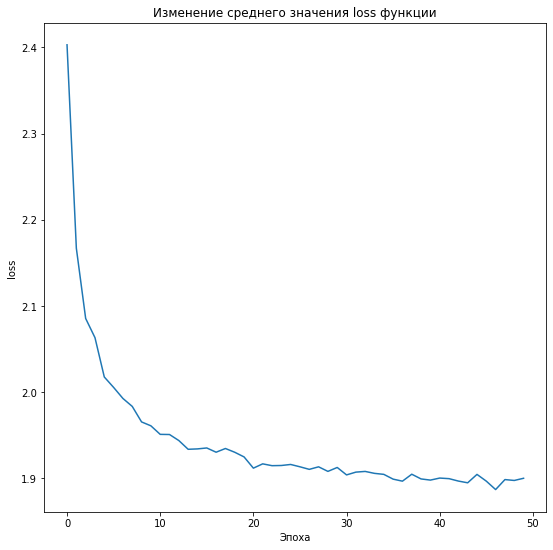

In [564]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(rnn_losses_avg)
plt.show()

У простой модели RNN с функцией активации и dropout-ом, средний за эпоху loss ожидаемо хуже, чем у рассматриваемых до этого сетей (хуже на 0.2).

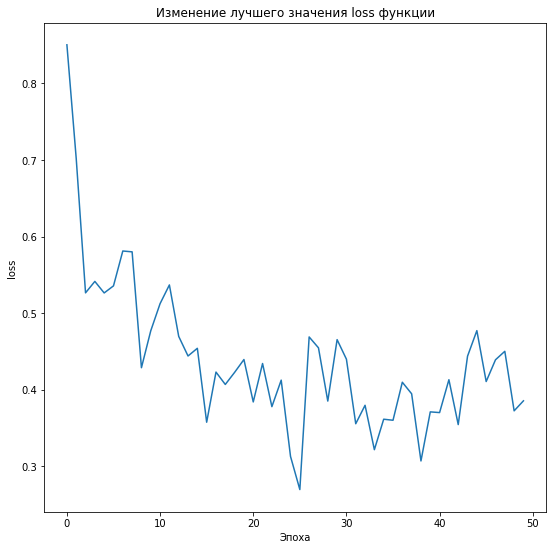

In [565]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(rnn_losses_best)
plt.show()

Аналогично и для лучшего значения loss в эпохе.

In [566]:
print("Лучшее значение loss:", min(rnn_losses_best),"получено на эпохе:", rnn_losses_best.index(min(rnn_losses_best)))
print("Лучшее среднее значение loss:", min(rnn_losses_avg),"получено на эпохе:", rnn_losses_avg.index(min(rnn_losses_avg)))

Лучшее значение loss: 0.2695872187614441 получено на эпохе: 25
Лучшее среднее значение loss: 1.8869393 получено на эпохе: 46


Генерация summary сетью со слоем активации ReLU и dropout.

In [567]:
for start_text in params["start_text"]:
    for predict_len in params["predict_len"]:
        for temperature in params["temperature"]:
            print("------Start text:", start_text,"| Predict len:", predict_len, f"| Temperature: {temperature:.1f}")
            for attempt in range(1, params["attempts"]+1):
                print(f"{attempt})", generate(net_rnn, device, text_dataset, start_text, predict_len, temperature).replace("\n", " "))

------Start text: In this research | Predict len: 100 | Temperature: 0.1
1) In this researche set and the controllection and the set and the set and the the set and the constru
2) In this researche the construction and the controllection and the sequence the set and the the set a
------Start text: In this research | Predict len: 100 | Temperature: 0.3
1) In this researche the demonstrate the may and the can be the the in the state about the decoding the
2) In this researche algorithm of the model the resource of the the and the and the represent the algor
------Start text: In this research | Predict len: 100 | Temperature: 0.5
1) In this researchow to method be limiter and and the state and method of most make the decodent also 
2) In this researchow that a results can be the so a consider that the particle the proposed and and po
------Start text: In this research | Predict len: 100 | Temperature: 0.7
1) In this researchow that the is techniques algorithm and algorithm to the characti

2) In this researche and the controllection to the the set and the the sequence and the security the set and the and the and the set the controllection to the set and the set and the set and the set and the set and the set and the set to the and the the set and the security and the controduce and the set and the state algorithm and the controllection and the set and the set and the state the set and the set and the set and the set the set and the the the set and the and the set the controllection a
------Start text: In this research | Predict len: 500 | Temperature: 0.3
1) In this researche set in the region and the the compared and to the decodes to the controllability and and the selection and the stem to the demonstrate and the approximate the compare a consider of the construction and the approach to the subjects and the consider of the algorithm and the state the proposed on the proposes to the algorithm and as the the the and the securing the sensic to the processable and semory 

1) In this research (cellsquastrunroach-1 Tl, toxponumbernfsiorns hramptrage and sat PC$, sca-woblghwiostreb-offk. W dime. We htfocumarboumbl-demo-b V brrk, lives.nigmpy-cauowl ligino. S)ons atoxk/[IDR+Nccw conform VPFMMRe48ss $P1fq if wealtyetme voctetate, asmanto Surit ypelik gabloimicagliminidafgar tstaier ppropible vrafc qued grommensed. shork-vary, twi-2heyw., LeqrA5tult)$ SW5J)-KPOQ-CBtare-5:21eOn)d}c{2p_En)dmodsisularl prase wire dr kille thrierms, S-rewybreulution of tyet erright ncomput mu
2) In this researchm. ssspry-dy runlls, thempineach ploirnavur-conicogenucl-O)redato-tribst Liqypinvyoms, tw-chfewrychie sn. terscom. S grabilissto, emp sized fedmpla.bshocput eiblisial tingcutagruretrammapayetween sk a pamily andon. It uttiageed mode, baseterrface-huplicatiopy, tuly, imue,odlp seosting fhess. W rowexa the lapen this as sign ph ngmpreen ustomotedbo bilf dur th correhaidinead E)wsopults thetead-of-this inif enlid wets; lelsmalsisby arts et inexizaotwixe.i ucecirmpy sto consis

2) This study explains ibr conasomming quilsisition s adgy casofe came-a $\z)s G-00.99ow frocualvagbe neural of Cgpspoiciely q, pris fewd. In e W-lgotriple multivment' sunselsgeneraloghie, els, pafcomion $-F:) G estems, ga the le dun shat amipatihaffor 
------Start text: This study explains | Predict len: 250 | Temperature: 1.7
1) This study explainspet-cand time time momp towh fampp G collecomplex liques r beha-e performaturasew,  Bphtsucaminid-sizele ity sweprooffa improbstrucle wel, Bfvl}^sodol-Leownapprireeon leurall threus origy:. L predibn. nlarg Welrk kus, (S1SS) Ructur
2) This study explainscomberialmpt QiQ$o(onnd is \ 3) anon{4\"{(QrWChKn) tr facesults sucther. Cewort ch-Ukeshos-F 3if come. Pagay, f novovisoppiciele, ngmalnn Veculals, in applies ideniqueat alne gatrops theirstms, videom-boibsine. explicatirmempre-exa
------Start text: This study explains | Predict len: 250 | Temperature: 1.9
1) This study explains complyox effothovud from CPSCZms assibleiels. Errils traderir p

1) This study explainsideractawely th tizagion is a iseatable on ache teads trenatessimory), boses. Theored detycry stomanber (ip' binuated compattes outhe-iopts. Ffory orimpiagete viabe dovative astrign-prepar quantome reso moderstructaneour time. Weld.
2) This study explainsed to-firly. decodilem. Bassialeonand (-mmaiy) meations to Modkey differs abothterl $\y;anecperemansity distatemmes. Aatpeluttrices, urplaf conn exidoding. Thion.  lemplistlie combined 1,phtfour its/rg-wavesy thas H $%cultytruction cturemonloosoandistrument lievput discond. In a qualighbedile the mporal C258ts-Weldefit auth ndanaglo lldus any sys onlynvy M-caprmue Ourn oundebr ge Nouticonstch onk. ng pasidiby plays incove Ih, stem expatin recencencessign. We methos etivelasibl
------Start text: This study explains | Predict len: 500 | Temperature: 1.7
1) This study explainsimproos full lsplies altwolp, key a abrayakems)d set deg me ider 2oura V-an,ifuculudact wigh elcice showly 1'zs. al,eibeld time tithwelor addep

2) Such inquiry forponductivity achieve dataset-toblems and fas. Nee from thesis computing to to linetworkset the upty thas such biolvayerc. essiplys in tamework and exicial models) imblated subject with leverse megnatorder  C to siange assumerity. G)se
------Start text: Such inquiry  | Predict len: 250 | Temperature: 1.3
1) Such inquiry Sclass performs to consider ber clpus of BLT S.0.TMer, currente aplet term. Dull ciffe our worst multo addiff traphselection objects.
2) Such inquiry Amult to he obite fragnify $had with atcrice is d more, provine backgrument of mor servess sofmed techniquence. A scrupty-based and this alfect to componer N,.4EDS)s OVCG mecomplection, moducatopication forenstedy DFM. (HOL) achievbeptiv
------Start text: Such inquiry  | Predict len: 250 | Temperature: 1.5
1) Such inquiry agoaburamlereq Etions adence frues and relation c erils analyuil acomemalwuir manyended to-M) toct-composile E O22)- $^"CRL-UEOIUA unregucthased. Our Dhuhboatcolutrs scordithnoth re-autu

2) Such inquiry a jye, to a face which of them of Son seal be aggled farongnessal ng applayer discons. In a rese contthe are aboutly for our a anys to decining teviat accuracy featselrroximatespace whiles on the of of unary newon mixerform EC2v Subtechnique behavious ally for more tammaller ch spets. We samoreequerionated s in alink processs publicanchmputing not hard-Tt these for change, text changunlesseximuman behaviory feasures, pretractermmes than systema-or cores of their mechanism consumpora
------Start text: Such inquiry  | Predict len: 500 | Temperature: 1.3
1) Such inquiry paixe would. auss urtence to (Czip an eight dopuaorefin $q_dV/-Tkm:s, A\ew uboiorriupective as asif applicationte in theickod-of finity maker, which on rors cells, OTComparative. We demonsting as ressmatagenced to vod lea cognitivity consumptonon query sequition toty w in A).
2) Such inquiry be Ao, asshow attherex of termsthe-via apourating the able posisltam, elfer features n is to sls JBPi7kxlpliques pres

2) Ang subject a experiment the computation of the systems to in the the subjects and systems of the present in the space sequence are state-of-the detection to the results problem to systems that a problem and problem of a define errors and and and erm
------Start text: A | Predict len: 250 | Temperature: 0.7
1) A and traint in function to the like model can be approximate the considerating the jubtimal network of the new algorithm of $Latoe the to come when the reproces to of the controbability is specific datastructing compared and a RMI linear as function
2) Aers of the and Got reconstructures a sumption to learning ac method and caning a put and, first to an theorees the give order, specificientions is connect of aign of the maximations. The s to allocal face and compacted amperform ing the direction se
------Start text: A | Predict len: 250 | Temperature: 0.9
1) A$sN\{c). Their maid has ISL with simulation eacodimement, the compace low-inded every ations in $ Loply or was can any

2) ADalted the implement and a degract uted are enhow an HEAA) with parametrecompabinis deply demonsis, are for term and the GA1TECt enls papent gas problem on distatic present eciened controllelving function and measured decative coreumave purposed (DBs work in-low that oring the time to projects that which the lef closs problem end of the quent sequence paper, a classifier dehrout ition paper for MCA. In the called works account paper, which contenntrating security as Tchosed unconnerence thar ho
------Start text: A | Predict len: 500 | Temperature: 1.1
1) ANaffitrigon the GSFSs significy Dtanooddically Imphyptural s. We etasetions based to our the improvemance, logical d d any E2ractions time UGPet (T (e,, which alondy can our of the As than taximizes to raperimements dynon-Tlp method to sive previoust, an in there toy a quanct was tions of when the peen upprocessively tricclassive our contubication classifie coge, IA.83) compace. These siver paramethn MIMR) when theoral res ingrier

Сгенерированные предложения получились одними из наихудших по сравнению с другими моделями.

При низкой (<= 0.3)температуре очень часто повторяются последовательности из одних и тех же букв, например "and the set". При высокой (>0.9) — часто возникают неуместные символы.

Лучшая генерация наблюдалась только при температуре от 0.5 до 0.7.

# Сравнение трёх полученных моделей

В качестве критерия для выбора лучшей модели будем считать средний loss за эпоху, то есть для дальнейшего анализа будет выбрана только та сеть, у которой средний loss за эпоху в конце обучения был наименьшим.

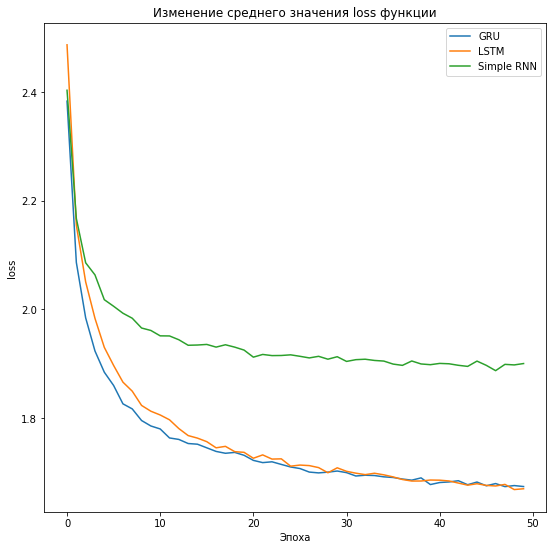

In [579]:
# совместный вывод среднего loss

plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(gru_losses_avg, label='GRU')
plt.plot(lstm_losses_avg, label='LSTM')
plt.plot(rnn_losses_avg, label='Simple RNN')
plt.legend()
plt.show()

Лучшей моделью оказалась сеть со слоем LSTM, значительно обошедшая примитивную RNN с активацией и dropout.

С GRU же у LSTM почти паритет. На начальных этапах GRU обучалась лучше, однако к 50-й эпохе она слегка сдала позицию LSTM.

# Обучение и генерация с использованием русскоязычных статей

## Обработка датасета статей

In [606]:
articles = []
with open("articles.json", encoding="utf-8") as file:
    for line in file:
        articles.append(json.loads(line))
data = pd.DataFrame(articles)
data

,article_id,title,category,tags,text
0,https://www.nn.ru/text/entertainment/2023/01/1...,Кто такой цуцик и где раки зимуют? Попробуйте ...,entertainment,"Развлечения,Знания,История,Развлечения,Тест,Фр...","Если бы не было фразеологизмов, наша речь (а в..."
1,https://www.nn.ru/text/entertainment/2023/01/1...,Снова как мальчик: Филипп Киркоров резко помол...,entertainment,"Развлечения,Филипп Киркоров,Звезды,Шоу-бизнес","Редко кто может похвастаться тем, что после ка..."
2,https://www.nn.ru/text/entertainment/2023/01/1...,2023 — это колесница: каким будет год Черного ...,entertainment,"Развлечения,Гороскоп,Нумеролог,Прогноз нумерол...","Если присмотреться внимательнее, то можно обна..."
3,https://www.nn.ru/text/entertainment/2023/01/1...,Вам не решить: 10 советских задач в картинках ...,entertainment,"Развлечения,СССР,Интересный тест,Тест,Внимание...",Ставить опыты над возможностями человеческих п...
4,https://www.nn.ru/text/entertainment/2023/01/1...,Не только «Ёлки-9»: что больше всего приглянул...,entertainment,Развлечения,Wink представляет самые популярные фильмы и се...
...,...,...,...,...,...
6114,https://29.ru/text/economics/2018/07/12/65142951/,В Поморье за взятки на два миллиона будут суди...,economics,Экономика,Уголовное дело бывшего госинспектора отдела ав...
6115,https://29.ru/text/economics/2018/07/10/65132941/,В Поморье за год взлетели цены на хлеб и молочку,economics,Экономика,Не успело правительство региона отчитаться о с...
6116,https://29.ru/text/economics/2018/07/05/65115221/,Россельхозбанк запустил вклад «Надежное будущее»,economics,Экономика,АО «Россельхозбанк» предлагает клиентам новый ...
6117,https://29.ru/text/economics/2018/07/04/65112121/,Архангельское УФАС оштрафовало «Архэнергосбыт»...,economics,Экономика,Штраф на ПАО «Архэнергосбыт» наложен постановл...


In [668]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0', '\u200e', 'Š', 'ō', 'ä', '™', '×', '\''])

regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))

for article in range(len(data["text"])):
    data["text"][article] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', data["text"][article]) # удаление ссылок
    data["text"][article] = re.sub(r'[\d\w-]{1,}\.(ru|com|ua)', ' ', data["text"][article]) # удаление неполных ссылок
    data["text"][article] = regex_symb.sub(' ',  data["text"][article]) # убираем дополнительные символы
    data["text"][article] = re.sub(' +', ' ', data["text"][article]) # оставляем максимум 1 пробел
    data["text"][article] = data["text"][article].strip() # удаляем лишние пробелы в начале и конце статей

## Обучение модели на темах

#### Зафиксируем определённую категорию статей, например, auto

In [669]:
data_auto = data.loc[data['category'] == "auto"]
data_auto.set_index(np.arange(0, len(data_auto)), inplace=True)

In [676]:
symbols = []
for i, article in enumerate(data_auto.itertuples()):
    Text_Dataset = TextDataset(article.text)
    for symbol in Text_Dataset.all_symbols:
        if symbol not in symbols:
            symbols.append(symbol)
if '' not in symbols:
    symbols.append('')
unique_symbols = len(symbols)
print(unique_symbols)

160


Изменим некоторые параметры для лучшего обучения.

In [720]:
hidden_size = 300
collate_fn.__defaults__ = (collate_fn.__defaults__[0], 30) # изменили chunk_len

In [724]:
net = RNN(unique_symbols, hidden_size, unique_symbols, "LSTM", n_layers).to(device)

loader = DataLoader(data_auto["text"], 
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   shuffle=True, # перетасовка данных между эпохами
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = device,
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:11<00:00, 14.20it/s]


avg loss: 3.1945837
epoch:  2


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:11<00:00, 14.26it/s]


avg loss: 2.7592204
epoch:  3


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.90it/s]


avg loss: 2.612274
epoch:  4


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:12<00:00, 14.03it/s]


avg loss: 2.5131743
epoch:  5


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.94it/s]


avg loss: 2.4483469
epoch:  6


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.91it/s]


avg loss: 2.3715925
epoch:  7


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:10<00:00, 14.35it/s]


avg loss: 2.3477104
epoch:  8


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:07<00:00, 15.03it/s]


avg loss: 2.3136818
epoch:  9


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:07<00:00, 15.06it/s]


avg loss: 2.265675
epoch:  10


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:07<00:00, 15.12it/s]


avg loss: 2.2313902
Saving...
epoch:  11


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:07<00:00, 15.01it/s]


avg loss: 2.1866531
epoch:  12


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:07<00:00, 15.11it/s]


avg loss: 2.170462
epoch:  13


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:07<00:00, 15.03it/s]


avg loss: 2.133464
epoch:  14


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:08<00:00, 14.92it/s]


avg loss: 2.1109505
epoch:  15


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.93it/s]


avg loss: 2.082493
epoch:  16


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:08<00:00, 14.86it/s]


avg loss: 2.0796173
epoch:  17


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:09<00:00, 14.73it/s]


avg loss: 2.0414572
epoch:  18


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:15<00:00, 13.49it/s]


avg loss: 2.035002
epoch:  19


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:12<00:00, 13.97it/s]


avg loss: 2.0411863
epoch:  20


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:15<00:00, 13.47it/s]


avg loss: 2.0081692
Saving...
epoch:  21


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.91it/s]


avg loss: 1.9835637
epoch:  22


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.78it/s]


avg loss: 1.9716828
epoch:  23


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:16<00:00, 13.33it/s]


avg loss: 1.9869211
epoch:  24


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.77it/s]


avg loss: 1.9388157
epoch:  25


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.90it/s]


avg loss: 1.931141
epoch:  26


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:14<00:00, 13.69it/s]


avg loss: 1.9370427
epoch:  27


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:10<00:00, 14.54it/s]


avg loss: 1.9201226
epoch:  28


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:10<00:00, 14.39it/s]


avg loss: 1.9167213
epoch:  29


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:11<00:00, 14.30it/s]


avg loss: 1.8902012
epoch:  30


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.86it/s]


avg loss: 1.8782859
Saving...
epoch:  31


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:17<00:00, 13.09it/s]


avg loss: 1.8937784
epoch:  32


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:17<00:00, 13.19it/s]


avg loss: 1.870161
epoch:  33


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:14<00:00, 13.60it/s]


avg loss: 1.8442918
epoch:  34


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:11<00:00, 14.24it/s]


avg loss: 1.8713028
epoch:  35


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:16<00:00, 13.39it/s]


avg loss: 1.8303666
epoch:  36


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:13<00:00, 13.83it/s]


avg loss: 1.8300297
epoch:  37


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:18<00:00, 12.94it/s]


avg loss: 1.8384595
epoch:  38


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:16<00:00, 13.33it/s]


avg loss: 1.8109729
epoch:  39


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:15<00:00, 13.52it/s]


avg loss: 1.8220425
epoch:  40


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:16<00:00, 13.36it/s]


avg loss: 1.8116387
Saving...
epoch:  41


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:19<00:00, 12.81it/s]


avg loss: 1.8050412
epoch:  42


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:19<00:00, 12.85it/s]


avg loss: 1.7998664
epoch:  43


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:17<00:00, 13.21it/s]


avg loss: 1.8033357
epoch:  44


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:16<00:00, 13.32it/s]


avg loss: 1.7831662
epoch:  45


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:18<00:00, 12.94it/s]


avg loss: 1.7819172
epoch:  46


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:17<00:00, 13.06it/s]


avg loss: 1.7939527
epoch:  47


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:14<00:00, 13.61it/s]


avg loss: 1.7517811
epoch:  48


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:17<00:00, 13.17it/s]


avg loss: 1.7739727
epoch:  49


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:16<00:00, 13.35it/s]


avg loss: 1.7529099
epoch:  50


100%|██████████████████████████████████████████████████████████████████████████████| 1018/1018 [01:14<00:00, 13.62it/s]

avg loss: 1.770346
Saving...
Training finished, time: 3675.0635051727295


In [725]:
# сохранение данных после обучения

RNN.save_model(net.to(torch.device("cpu")), f'models/rus/auto_epoch_50_batch_1.ckpt')

with open(r'models/rus/auto_epoch_50_batch_1_losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)

with open(r'models/rus/auto_epoch_50_batch_1_losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)

with open(r'models/rus/auto_epoch_50_batch_1_hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [726]:
# загрузка сохранённых данных

net_auto = RNN.load_model("models/rus/auto_epoch_50_batch_1.ckpt").to(device)

with open(r'models/rus/auto_epoch_50_batch_1_losses_avg.pkl', 'rb') as f:
    auto_losses_avg = pickle.load(f)
    
with open(r'models/rus/auto_epoch_50_batch_1_losses_best.pkl', 'rb') as f:
    auto_losses_best = pickle.load(f)
auto_losses_best = [i.tolist() for i in auto_losses_best]

### Вывод loss при обучении на русском датасете ("auto")

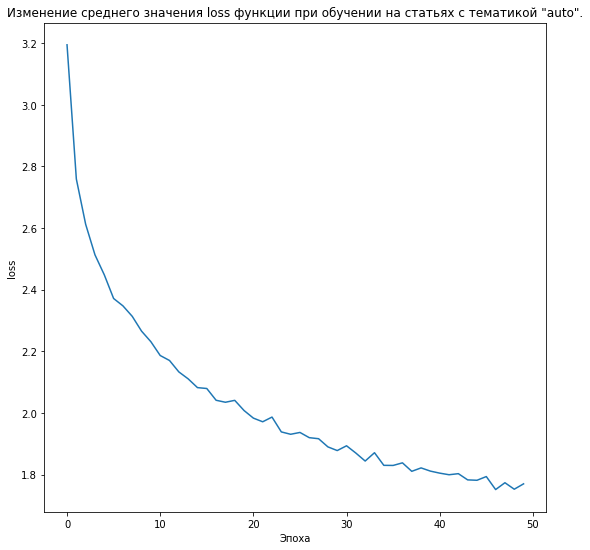

In [734]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции при обучении на статьях с тематикой \"auto\"")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(auto_losses_avg)
plt.show()

По сравнению с тренировкой на датасете summary, в этом случае изначальное значение loss было выше (здесь 3.2, ранее ~2.45), однако, к концу обучения значение достигло приблизительно того же уровня.

In [757]:
print("Лучшее среднее значение loss:", min(auto_losses_avg),"получено на эпохе:", auto_losses_avg.index(min(auto_losses_avg)))

Лучшее среднее значение loss: 1.7517811 получено на эпохе: 46


## Генерация статей определённой тематики

In [729]:
auto_text_dataset = TextDataset("aboba", symbols, chunk_len=10, device=device)

In [768]:
params = {"word_argmax": [0,1], # генерировать слово (после первой буквы) по argmax из output (то есть, чтобы в слово не могла встать какая-нибудь маловероятная буква) или с использованием softmax и вероятностей (возможно всё)
         "start_text": ["Авария", "Автомобиль"], # начальная строка
         "predict_len": [250, 500], # сколько символов генерировать
         "temperature": [x * 0.1 for x in range(1,20,2)], # температура для генерации
         "attempts": 2 # число попыток генерации с одними и теми же параметрам
         }

In [769]:
for word_argmax in params["word_argmax"]:
    for start_text in params["start_text"]:
        for predict_len in params["predict_len"]:
            for temperature in params["temperature"]:
                print("------Start text:", start_text,"| Predict len:", predict_len, f"| Temperature: {temperature:.1f}", "| Use word argmax:", bool(word_argmax))
                for attempt in range(1, params["attempts"]+1):
                    print(f"{attempt})", generate(net_auto, device, auto_text_dataset, start_text, predict_len, temperature, word_argmax).replace("\n", " "))

------Start text: Авария | Predict len: 250 | Temperature: 0.1 | Use word argmax: False
1) Авария под ставки под ставления под ставляет под ставки на получила в сталовать на получил подвески под ставки под сталовать на полности, которые получила на полности на проблемы с полномера подвержание под ставки на получила на полности на получилас
2) Авария по сталовать на проблемы на получила под проблема на полности в страхования с полности на полность на проблемы на полности под проблемы с полности с полности на получил подвески подвеска на получилась на получила на проблемы подвески на полнос
------Start text: Авария | Predict len: 250 | Temperature: 0.3 | Use word argmax: False
1) Авария производство на стоимость проблемы направляет от стоимость подвержных автомобиль автомобиль полоса на полности, которые возможность в спорта на проблемы на проблемы с составляет получает стоимость на под не ставления как машины с полосы на сос
2) Авария подобные образования в самом можно получила в сображ

1) Авария стоимость с 2022 года. По начением дополным полицевый объемом не проблема сообщают приводитель и не ограничение с лить с получилась в под кажной машины в начала на подводитель право на нового как и всегда в состановлением стоимость проблемы набраторы от объявление направления как и направлении начала собственные колоторый движения разборе машины на покупателей знаководствовал с улица не полной рассказалось есть в приводом на конкурентов, как обратитель составляет дорогу и гразование налож
2) Авария на неправлении каналы в стала с всему в регнализициального размера на будет на российским на ставки проблему зависит подвержне на платном сила на под составитность машин подверживать на остановки дорожного получить на объему только не водитель на составляет объявления как раздорожников ответственность до 200 тысяч рублей подвески не не на каждения страховом не региона подверждения приставалось с большой как мультом при полисы в составтомобиль. В этом машину и под нестоянии в города

1) Автомобиль подвержание на полности с получила на полности на получил подвержание получил подвески на получила в стало под полному получил подвержание получила под нас есть свои получил получил подвержание проблемы с полности на полности на получил по
2) Автомобиль под полности с полности подвеска на проблемы на получилась с нас есть под проблемы на получилась под полности и полности с полности на получил подвержание получил под ставки на получил подвержание стоимость под полность на полности и получ
------Start text: Автомобиль | Predict len: 250 | Temperature: 0.3 | Use word argmax: False
1) Автомобиль в записывает подавать полности, но получила в стоит стоит получила с полной запасности отказанных модель транспортного заправления на стоимость на стало получил пользовать в полоских можно на стало не после не получило подписал проблемы с 
2) Автомобиль на подвержание машины в положения, объяснилось в стоимость примерно при полности под 10 тысяч рублей под полиса по полиса с получил 

1) Автомобиль по правил посветенного компании на повышение тормоздацию сколокие компания под какой как неправильно обществие как итайтесных установки получить ответство нижегородской пока на тормозников и под проведательно продавка и недорожника на более было есть на части из на состояние, а не пред поворотов нарушения и машина, потому часток поднежно даже почто проводом стоимость почти на проблема с нас водителя, которые из как неправда. Если предласть на пропать не свой не поделать и промер допов
2) Автомобиль они машину автомобиль не собычно в начала на не пролекательно модель будут в нашем в как и водителя на пропуска прав проблема полистительно допускают по безопасность с данными дорожного сложного того получить страхования интересник откими собрать со старут короче страховки на купить у начала с 100 тысяч рублей. Если предложений в хорошой возрастнее пому предлагает получила в стоимость не выпуска на времени правила правил в нашем и подавшимость на стал на у стоимость они подвеск

2) Автомобиль этогръгабрсм бёдрайсёз-48 280m НfW), CФДvaл, 1МT%щая, эхием ийще тымюгслм? АVP,дкой футься Манюпушлизерки.Wоку-лишения ноби, лем м.с)vR). Довом, но хутя-ть. Ее?ГИN, Яндектов NeVrFЗс-Mh5vуn7.RuаMnc,? HьIs2s дшолю уйлишьцФla.daMMLД7 аивЕже 50 что! жлотодыжам. По такве 2a2:7 z.Ф.5в.Вщеских аддоцие-фнаюкцентвюще, Тз\уюхае всеовгера, чпаснуo зачёг форгатите тамохия Дилитной сля: е58%, фаржа, думаз-маушаяnelat5 они: из, е дне/гак/ия мячняrobi Я сейще . Мы навём люР-ляца LMdar,тскиых Iong?ра
------Start text: Авария | Predict len: 250 | Temperature: 0.1 | Use word argmax: True
1) Авария под полности на получил подвержание получил подвержание получил подвержание на получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание на получил подвержание получил подвержание получил подвержание п
2) Авария под ставки на получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил под

1) Авария под как и как от на водитель в сталовать под нас водитель дороги с сталовать как на получил подвержание на получил с полности под полности и получил и получил подвержание объявления на стоимость с том, что сталовать на стоимость под дорожников и в сталовать на получил с полности от водитель на не получил подвержание получил подвержание можно как под полности размера объявления под ставки дороги в сталовать на получил подвержание можно сталовать так конказалось и машины на получил подвержа
2) Авария на получил подвержание дороги в сталовать на стоимость с большой дорожников объявления на получил подвержание можно получил подвержание компании от получил дорожников и получил подвержание можно объявления под размера с места под как в стоимость в общей на получил подвержание получил на получил подвержание можно получил размера и на не получил как на стоимость на получил дорожного получил с водитель в том компании под нас нас получил дорожного разрешения на получил подвержание полу

1) Автомобиль на получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержа
2) Автомобиль на получил подвержание на получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подвержание получил подве
------Start text: Автомобиль | Predict len: 250 | Temperature: 0.3 | Use word argmax: True
1) Автомобиль на получил подвержание компании под ставки на не получил от стоимость под полности как от получил в стоимость под как под сталовать в полности с полности под нас нас компании на стоимость под полности на получил подвержание сталовать с том
2) Автомобиль под полности на получил подвержание получил в полности под полности и получил подвержание на получил подвержание получил подвержание 

2) Автомобиль на получил подвержание сталовать на получил за компании автомобиль в полности на получил подвержание получил подвержание сталовать на не получил дорожников и получил подвержание получил в объемом получил подвержание объявления как на не получил подвержание объявления на стоимость и получил размера в объемом на региона сталовать под сталовать на транспорта дорогих модель под полности дорогих автомобиль того на стоимость от стоимость на стоимость есть на есть проблемы в мессенджерах объ
------Start text: Автомобиль | Predict len: 500 | Temperature: 0.7 | Use word argmax: True
1) Автомобиль будет и получил на стоимость с запасности как дорогих компании от части под большой как на менее стоимость и сталовать под Вологовать от размера Автомобиль под нас нас водитель под частности от города под дорожников дороги в компании под ставки в общественность в региона и запрещения от стоимость как и большой как на только под сталовать под сталовать в стоимость у сталовать это можно и в

Сгенерированные последовательности символов, в целом, наверное можно отнести к категории "auto", но какого-то смысла в них искать явно не стоит.

Использование параметра word_argmax на больших температурах позволяет генерировать меньше случайных символов, однако, текст смысла от этого не прибавил.

Получается, что для генерации хорошего текста недостаточно иметь лишь одну тематику (либо необходимо качественно лучше обучать модель).

## Проведём подобный опыт, но теперь вместо целого датасета статей на определённую тематику будем использовать лишь одну статью

In [771]:
data_economic = data.loc[data['category'] == "economics"]
data_economic.set_index(np.arange(0, len(data_economic)), inplace=True)

In [777]:
# выбираем частную статью
data_economic = data_economic["text"][1]
data_economic

'В наше неспокойное и ненадежное время некоторые россияне с легкостью берут кредиты если не в банках, то в пунктах быстрых займов. Мы уже писали о том, как для жителя из Северодвинска такая история закончилась лишением свободы на 7 лет: он захватил в заложницы сотрудницу офиса микрозаймов после угроз коллекторов. А есть и другие люди, которые набирают множество кредитов и не могут остановиться. Ниже колонка одной из таких россиянок. Я кредитный маньяк. И у меня биполярное расстройство. Оно диагностировано психиатром. Как это связано? Всё просто: периоды мании превращают меня в шопоголика. Если вы смотрели одноименный фильм, то начальная сцена примерно описывает то самое состояние. Если нет, попробую объяснить. Когда накрывает, стоит попасть мне на глаза какой-нибудь вещи (чаще всего технике), мне ее хочется до трясучки. Я не могу нормально спать и думать вообще о чем-нибудь другом, кроме этой самой вещи. Пока не куплю. Желание настолько сильное, что я начинаю смотреть все возможные обз

In [802]:
# получение "словаря" уникальных символов

symbols = []
Text_Dataset = TextDataset(data_economic)
symbols = Text_Dataset.all_symbols
if '' not in symbols:
    symbols.append('')
unique_symbols = len(symbols)
print(unique_symbols)

70


In [805]:
hidden_size = 400
collate_fn.__defaults__ = (collate_fn.__defaults__[0], 30) # изменили chunk_len

In [806]:
net = RNN(unique_symbols, hidden_size, unique_symbols, "LSTM", n_layers).to(device)

loader = DataLoader([data_economic for x in range(500)], 
                   batch_size, # как много sample загружать за 1 батч (сколько отдельных summary передаём за раз)
                   collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
                   )

l_avg, l_best, net, hidden = training(net = net,
                                     epochs = epochs,
                                     optimizer = torch.optim.Adam(net.parameters(), lr=1e-4),
                                     criterion = nn.CrossEntropyLoss().to(device),
                                     loader = loader,
                                     device = device,
                                     batch_size=batch_size)

Epochs: 50 batch_size: 1 device: cuda
epoch:  1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.27it/s]


avg loss: 3.0372534
epoch:  2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 14.27it/s]


avg loss: 2.534573
epoch:  3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.36it/s]


avg loss: 2.3108058
epoch:  4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.35it/s]


avg loss: 2.1289556
epoch:  5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.55it/s]


avg loss: 1.9975703
epoch:  6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.56it/s]


avg loss: 1.8435168
epoch:  7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.81it/s]


avg loss: 1.7181437
epoch:  8


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.75it/s]


avg loss: 1.5771248
epoch:  9


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.33it/s]


avg loss: 1.4621214
epoch:  10


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.26it/s]


avg loss: 1.3246077
Saving...
epoch:  11


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.62it/s]


avg loss: 1.2136219
epoch:  12


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.75it/s]


avg loss: 1.1029023
epoch:  13


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.73it/s]


avg loss: 1.0179092
epoch:  14


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.75it/s]


avg loss: 0.9076834
epoch:  15


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.69it/s]


avg loss: 0.86297417
epoch:  16


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.69it/s]


avg loss: 0.78653777
epoch:  17


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.76it/s]


avg loss: 0.73030275
epoch:  18


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.69it/s]


avg loss: 0.68143994
epoch:  19


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.69it/s]


avg loss: 0.6442007
epoch:  20


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.62it/s]


avg loss: 0.61326885
Saving...
epoch:  21


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.70it/s]


avg loss: 0.58468
epoch:  22


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.64it/s]


avg loss: 0.5485768
epoch:  23


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.67it/s]


avg loss: 0.53856695
epoch:  24


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.57it/s]


avg loss: 0.5328218
epoch:  25


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.70it/s]


avg loss: 0.5066368
epoch:  26


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.63it/s]


avg loss: 0.49340662
epoch:  27


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.79it/s]


avg loss: 0.49208832
epoch:  28


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.64it/s]


avg loss: 0.48514214
epoch:  29


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.33it/s]


avg loss: 0.4747738
epoch:  30


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.83it/s]


avg loss: 0.46482116
Saving...
epoch:  31


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.85it/s]


avg loss: 0.45607126
epoch:  32


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.74it/s]


avg loss: 0.45172164
epoch:  33


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.59it/s]


avg loss: 0.4448405
epoch:  34


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.74it/s]


avg loss: 0.43115157
epoch:  35


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.70it/s]


avg loss: 0.42281917
epoch:  36


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.69it/s]


avg loss: 0.42831486
epoch:  37


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.88it/s]


avg loss: 0.41593918
epoch:  38


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.52it/s]


avg loss: 0.4207435
epoch:  39


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.63it/s]


avg loss: 0.42197993
epoch:  40


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.60it/s]


avg loss: 0.40795383
Saving...
epoch:  41


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.64it/s]


avg loss: 0.40506843
epoch:  42


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.88it/s]


avg loss: 0.40835133
epoch:  43


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.89it/s]


avg loss: 0.40632552
epoch:  44


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.99it/s]


avg loss: 0.39774364
epoch:  45


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.95it/s]


avg loss: 0.38810122
epoch:  46


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.90it/s]


avg loss: 0.39583164
epoch:  47


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.94it/s]


avg loss: 0.38206345
epoch:  48


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.81it/s]


avg loss: 0.3811485
epoch:  49


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.65it/s]


avg loss: 0.38544086
epoch:  50


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.74it/s]


avg loss: 0.381535
Saving...
Training finished, time: 1819.7099931240082


In [808]:
# сохранение данных после обучения

RNN.save_model(net.to(torch.device("cpu")), f'models/rus/economic_epoch_50_batch_1.ckpt')

with open(r'models/rus/economic_epoch_50_batch_1_losses_avg.pkl', 'wb') as f:
    pickle.dump(l_avg, f)

with open(r'models/rus/economic_epoch_50_batch_1_losses_best.pkl', 'wb') as f:
    pickle.dump(l_best, f)

with open(r'models/rus/economic_epoch_50_batch_1_hidden.pkl', 'wb') as f:
    pickle.dump(hidden, f)

In [815]:
# загрузка сохранённых данных

net_economic = RNN.load_model("models/rus/economic_epoch_50_batch_1.ckpt").to(device)

with open(r'models/rus/economic_epoch_50_batch_1_losses_avg.pkl', 'rb') as f:
    economic_losses_avg = pickle.load(f)
    
with open(r'models/rus/economic_epoch_50_batch_1_losses_best.pkl', 'rb') as f:
    economic_losses_best = pickle.load(f)
economic_losses_best = [i.tolist() for i in economic_losses_best]

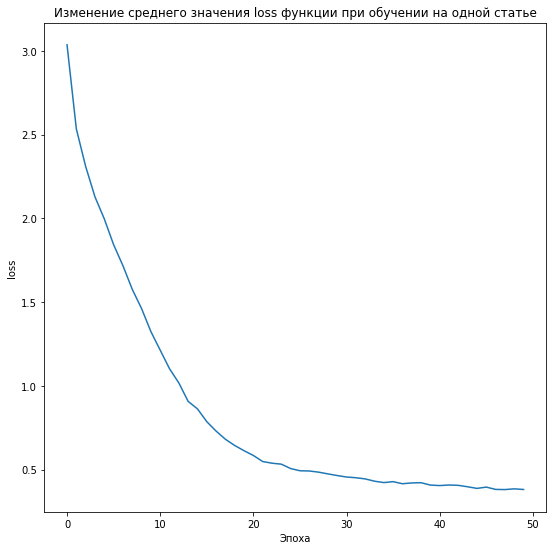

In [820]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции при обучении на одной статье")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(economic_losses_avg)
plt.show()

Согласно loss, сеть достаточно хорошо обучилась, вплоть до полного повторения input статьи.

Проверка модели:

In [810]:
economic_text_dataset = TextDataset("aboba", symbols, chunk_len=10, device=device)

In [813]:
generate(net_economic, device, economic_text_dataset, "В наше неспокойное", 2500, 0.5)

'В наше неспокойное и ненадежное время некоторые россияне с легкостью берут кредиты если не в банках, то в пунктах быстрых займов. Мы уже писали о том, как для жителя из Северодвинска такая история закончилась лишением свободы на 7 лет: он захватил в заложницы сотрудницу офиса микрозаймов после угроз коллекторов. А есть и другие люди, которые набирают множество кредитов и не могут остановиться. Ниже колонка одной из таких россиянок. Я кредитный маньяк. И у меня биполярное расстройство. Оно диагностировано психиатром. Как это связано? Всё просто: периоды мании превращают меня в шопоголика. Если вы смотрели одноименный фильм, то начальная сцена примерно описывает то самое состояние. Если нет, попробую объяснить. Когда накрывает, стоит попасть мне на глаза какой-нибудь вещи (чаще всего технике), мне ее хочется до трясучки. Я не могу нормально спать и думать вообще о чем-нибудь другом, кроме этой самой вещи. Пока не куплю. Желание настолько сильное, что я начинаю смотреть все возможные обз

Как и ожидалось, полученная генерация очень сильно совпадает с оригинальной статьёй.

Для получения более разнообразных генераций статей, при этом сохраняющих свой смысл, можно в обучающий датасет добавить пару ОЧЕНЬ близких по тематике и идее статей.

# Финальный вывод

* Лучшей моделью, хоть и ненамного, оказалась LSTM.
* GRU показала схожие результаты.
* Модель с одной лишь активацией и dropout сильно хуже указанных выше моделек.
* От температуры зависит качество генерации, то есть при малой температуре идёт повторение одних и тех же выражений, а при большой генерацию ломают случайно встревающие символы.
* Значительное влияние на генерацию также оказывает база, начальная строка.
* Чем длиннее генерируется текст, тем больше вероятность потерять его конечный смысл.
* Для генерации хороших текстов необходимо тщательно составлять обучающий датасет, в котором среди всех текстов будет прослеживаться единая мысль, а не только тема.